In [ ]:
!pip install qiskit 
!pip install pylatexenc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [80]:
import qiskit as qk
from qiskit.algorithms import optimizers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris as iris
from typing import Optional,Callable,NoReturn,NewType,Any,List,Dict,Union,Tuple
import math
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit,execute
import qiskit.tools.jupyter
import random
%qiskit_version_table

In [81]:
def create_circuit(width,depth):
    circuit=qk.QuantumCircuit(width)
    depth_now=0
    parameter=[qk.circuit.Parameter('p%02d'%i) for i in range(2)]
    theta=[qk.circuit.Parameter('/theta%02d'%i)for i in range(depth*width)]
    for i,o in enumerate(parameter):
        circuit.ry(o,i%width)
    for i in range(width):
        for j in range(width):
            if j>i:
                circuit.cx(i,j)
    circuit.barrier()
    
    for i in range(depth):
        for j in range(width):
            circuit.ry(theta[i*width+j],j)
        if i==depth-1:continue
        for j in range(width):
            for k in range(width):
                if j>k:
                    circuit.cx(j,k)
        circuit.barrier()
    #circuit.measure_all()
    return circuit


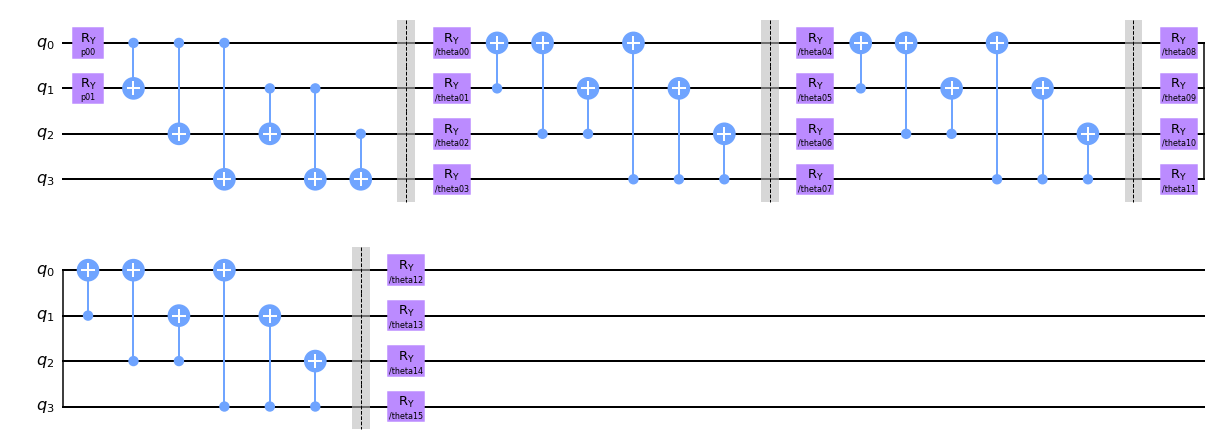

In [82]:
circuit=create_circuit(4,4)
circuit.draw('mpl')

[[9.260949830651906, 0.6848770951963807], array([3.07890532e-13, 9.10015250e-11, 1.39885498e-08, 1.11832596e-06,
       4.64981641e-05, 1.00548338e-03, 1.13079966e-02, 6.61406008e-02,
       2.01197365e-01, 3.18308422e-01, 2.61906127e-01, 1.12076581e-01,
       2.49434074e-02, 2.88714353e-03, 1.73801154e-04, 5.44137461e-06])]


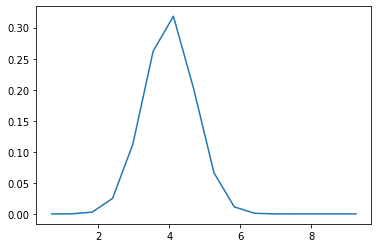

In [191]:
from sklearn.preprocessing import normalize

def gaussian(mu, sigma, x):
    return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2))

data=[]
num_point = 16
for i in range(100):
    mu=random.random()*10
    sigma=random.random()


    x = np.linspace(mu, sigma, num_point)
    y = gaussian(4,1, x)
    y = normalize(y[:,np.newaxis], axis=0).ravel()**2

    data.append([[mu,sigma],y])

plt.plot(x, y)
print(data[99])


In [145]:
from qiskit.visualization import circuit_visualization
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI, Hessian,CircuitGradient
from qiskit.opflow import Z, X, I, StateFn, CircuitStateFn, SummedOp
simulator=qk.BasicAer.get_backend('statevector_simulator')

def model(theta,state='train'):
    global circuit,param,loss_record,result
    loss=0
    iter=0
    for i in data:
        iter+=1
        #print(i[0])
        parameter=i[0].copy()
        data_y=i[1]
        #print(i[1])
        for j in theta:
            #print(j)
            parameter.append(j)
            #print(len(parameter))
        #print(len(parameter))
        #print(parameter)
        param=theta
        circuit_n=circuit.assign_parameters({circuit.parameters[ii]:o\
                                            for ii,o in enumerate(parameter)})
        job=execute(circuit_n,simulator)
        result=job.result().get_statevector().real**2
        loss+=sum((data_y-result)**2)
        if state=='test':
            plt.plot(data_y)
            plt.plot(result)
            plt.show()
        #print(iter)
        
    
    #plt.plot(result.real)
    #plt.plot(y)
    #plt.show()
    print(loss)
    return loss

In [246]:
import multiprocessing as mp
import threading as td
def new_model(para):
    global circuit
    para1,para2=para[0],para[1]
    para1=list(para1)
    parameter=para1.copy()
    data_y=para1[1]
    for j in para2:
        parameter.append(j)
    param=para2
    circuit_n=circuit.assign_parameters({circuit.parameters[ii]:o\
                                        for ii,o in enumerate(parameter)})
    job=execute(circuit_n,simulator)
    result=job.result().get_statevector().real**2
    #print(sum((data_y-result)**2))
    loss=sum((data_y-result)**2)/100
    return loss
    
def model(theta):
    global circuit,loss_record,loss_record
    loss=0
    iter=0
    param=[]

    for i in data:
        param.append([i[0],theta])
    #print(len(param))

    # use threading to parallel execute a function with a list of parameters
    def new_model_parallel(para):
        with mp.Pool(mp.cpu_count()) as p:
            result=p.map(new_model,para)
        return result

    result=new_model_parallel(param)
    loss=sum(result)
    #print(result)
    #print(loss)
    print(loss)
    #plt.plot(result.real)
    #plt.plot(y)
    #plt.show()
    #print(loss)
    return loss

In [247]:
def gradient(f,x,eps=1e-8):
    x=np.array(x,dtype=float)
    gradient=[]
    for i,o in enumerate(x):
        x_p=x.copy()
        x_m=x.copy()
        x_p[i]+=eps
        x_m[i]-=eps
        gradient.append((f(x_p)-f(x_m))/2/eps)
    return gradient

In [249]:
loss_record=[]
adam = optimizers.ADAM(lr=0.1,eps=1e-10)
result = adam.minimize(model,np.random.uniform(-7,7,16))

100
[0.04741402502745583, 0.10766956917034742, 0.1182434546761341, 0.11948951031959147, 0.002138726290149132, 0.008241575355944162, 0.013222431192746336, 0.027671039616400415, 0.023042437738371016, 0.004856474737982989, 0.0081873787065519, 0.0019693236097338244, 0.001364875584033246, 0.0013804150509000388, 0.03914732019846854, 0.05186753631736111, 0.1406434426749159, 0.08853614389439121, 0.1092862640192483, 0.014675597513579658, 0.10757538757843024, 0.04946575196050274, 0.03443586010124774, 0.11531459154477097, 0.08974716983452463, 0.027658192253966325, 0.110728293077717, 0.001904954957249405, 0.1130609725185014, 0.08498007275079356, 0.07164430503371119, 0.13396732343451032, 0.13151784698421667, 0.0013147480569888083, 0.0252776190666768, 0.023183806231074328, 0.036383681446365904, 0.0019648677045128343, 0.00129710243933596, 0.0006114745316670949, 0.009481403326233505, 0.035151370044454205, 0.05367379748475159, 0.0009442115389628228, 0.09902627171757372, 0.003166670953571555, 0.02442645

Process ForkPoolWorker-463:
Process ForkPoolWorker-462:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()


KeyboardInterrupt: ignored

In [143]:
model(param,'test')

TypeError: ignored